# Inspect Twitter Data

In [1]:
import os

# change the working directory to the root of the project
os.chdir("../")
print(os.getcwd())

/home/jsonpy/Projects/Practical/twitter-query-expansion


In [4]:
import pandas as pd
import json
import numpy as np
import configparser

from IPython.display import display
from sqlalchemy import create_engine, inspect

config = configparser.ConfigParser()
config.read('auth/pg-credentials.ini')

['auth/pg-credentials.ini']

In [5]:
# establish connection to database via postgresql client
engine = create_engine(f'postgresql://{config["POSTGRES"]["USER"]}:{config["POSTGRES"]["PWD"]}@{config["POSTGRES"]["URL"]}/{config["POSTGRES"]["DB"]}')

***
## Database Overview

In [6]:
inspector = inspect(engine)

# inspect tables
tables = inspector.get_table_names()

In [7]:
for t in tables:
    print(t)
    display(pd.read_sql_query(f'select * from "{t}" limit 3', con=engine))


conversation


,id,tweets
0,1454842489593028609,[1454842489593028609]
1,1454805472154882050,[1454918236647174145]
2,1454838863537577984,[1454838863537577984]


hashtag


,id,txt
0,8,krone
1,9,luftreinigungsgeräte
2,14,fragebogen


hashtag_posting


,tweet_id,hashtag_id,pos_start
0,1422134913848029187,1,15
1,1422134915185905664,2,46
2,1421724714683322369,3,29


tweet


,id,conversation_id,author_id,retweet_count,reply_count,like_count,created_at,txt
0,1454945694138224645,1454945694138224645,2797812265,0,3,8,2021-10-31 22:57:39+00:00,DANKE all den tollen Mitarbeitern im Tourismus...
1,1454950098790719490,1454950098790719490,52024480,111,0,0,2021-10-31 23:15:09+00:00,RT @ohneKlippo: Ich kann Männer nur davor warn...
2,1454949949548941313,1454949949548941313,1238114345361518593,105,0,0,2021-10-31 23:14:34+00:00,"RT @Dieter_Stein: 16 Jahre an der Regierung, 2..."


named_entity


,id,txt
0,11,TUN
1,21,Drachenfels
2,22,Herschdorf


named_entity_posting


,tweet_id,named_entity_id,pos_start
0,1422085655274917889,1,26
1,1421832547487690755,2,226
2,1421775312145338375,3,62


twitter_user


,id,follower_count,tweet_count,typ,created_at,twitter_name,real_name
0,2629261,3553,24656,politician,2007-03-28 06:58:38+00:00,hschmidt,Hansjörg Schmidt
1,5876652,761419,6099,lobby,2007-05-08 21:10:26+00:00,saschalobo,Sascha Lobo
2,9655032,409348,49843,lobby,2007-10-24 14:34:50+00:00,netzpolitik,netzpolitik


---
## Filter Tweets by word amount
Check how many tweets remain for different amounts of words within a Tweet.

In [5]:
import numpy as np 

num_tweets = pd.read_sql_query("SELECT count(*) FROM tweet", con=engine).get("count").item()

min_words = np.linspace(5, 60, 12, dtype=np.uint)
tweet_count = []

for l in min_words:
    query = (
        "SELECT COUNT(*) FROM ("
        "SELECT t.txt, t.word_count "
        "FROM (SELECT txt, array_length(string_to_array(regexp_replace(txt,  '[^\w\s]', '', 'g'), ' '), 1) AS word_count FROM tweet) AS t " 
        f"WHERE word_count >= {l} "
        ") AS c"
    )
    res = pd.read_sql_query(query, con=engine)

    # get number of tweets as percentage
    tweet_count.append((l, res.get("count").item()))

Display the amount of remaining Tweets after filtering.

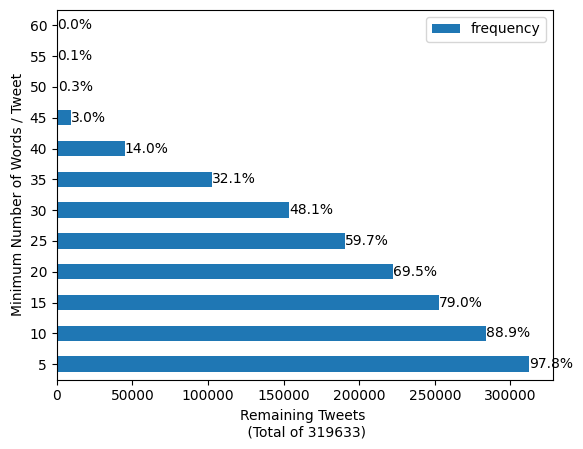

In [6]:
df = pd.DataFrame(tweet_count, columns=['min words', 'frequency'])

ax = df.plot(kind='barh', x='min words')
ax.set_xlabel(f"Remaining Tweets \n (Total of {num_tweets})")
ax.set_ylabel("Minimum Number of Words / Tweet")

percentages = df['frequency'].apply(lambda x: (x/num_tweets)*100)
labels = percentages.round(1).astype('str') + '%'

for container in ax.containers:
    ax.bar_label(container, labels)

---
## Get Hashtags in Tweets

In [8]:
from pipeline.src.utils import es_connect, pg_connect, get_project_root
import json

pg_client = pg_connect(credentials=config["POSTGRES"])
pg_cursor = pg_client.cursor()

Connecting to PostgreSQL database...
Successfully connected to localhost:5432


In [5]:
query_1 = (
    "SELECT *, STRING_AGG(ht.txt,' ') AS hashtags "
    "FROM tweet tw "
    "LEFT OUTER JOIN hashtag_posting hp ON hp.tweet_id = tw.id "
    "LEFT OUTER JOIN hashtag ht ON ht.id = hp.hashtag_id "
    "GROUP BY tw.id "
    "LIMIT 10"
)

query_2 = (
    #"SELECT count(*) FROM ( "
    "SELECT tw.id, tw.retweet_count, tw.reply_count, tw.like_count, tw.created_at, tw.txt, array_agg(ht.txt) AS hashtags, array_length(string_to_array(regexp_replace(tw.txt,  '[^\w\s]', '', 'g'), ' '), 1) AS word_count "
    "FROM tweet tw "
    "LEFT OUTER JOIN hashtag_posting hp ON hp.tweet_id = tw.id "
    "LEFT OUTER JOIN hashtag ht ON ht.id = hp.hashtag_id "
    "GROUP BY tw.id "
    #") as q "
    #f"WHERE q.word_count >= {25} "
)

query_3 = (
    "Select count(*) from ( "
    "SELECT array_length(string_to_array(regexp_replace(txt,  '[^\w\s]', '', 'g'), ' '), 1) AS word_count FROM tweet "
    ") as q "
    "where q.word_count >= 25"
)

pg_cursor.execute(query=query_2)
pg_cursor.fetchmany(10)

[(1421607583631171593,
  0,
  0,
  1,
  datetime.datetime(2021, 8, 1, 1, 3, 54, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))),
  '@StillePost6 @Alice_Weidel @Tino_Chrupalla @StBrandner @MdB_Lucassen Super. Klarnamenverweigerer und FalscheGräfinRetweeter.',
  [None],
  9),
 (1421609361080733702,
  0,
  1,
  0,
  datetime.datetime(2021, 8, 1, 1, 10, 58, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))),
  '@DannyHillborou1 @Bettina_Jarasch @kaddinsky @GrueneFraktionB Knappheit? Anzahl Wohnungen stieg in den letzten 30 Jahren schneller als die der Einwohner. Wohnfläche je Einwohner von ca. 27 auf 40qm heute. Mietpreise vervielfacht.\n50fache war nicht der Spitzenwert.\n"Möbliert" &amp; befristet - Umgehung mietrechtlicher Beschränkungen. Massenhaft.',
  [None],
  40),
 (1421609691956797444,
  0,
  11,
  9,
  datetime.datetime(2021, 8, 1, 1, 12, 17, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))),
  '@CarloMasala1 Das ist der Punkt. Dieser Kurs wird aber